In [2]:
# Import required libraries
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

# Activate automatic conversion between R and pandas
pandas2ri.activate()
readRDS = robjects.r['readRDS']

In [3]:
def process_session(file_path):
    """
    Process a session file from the RDS format.
    This is the same function used in our original analysis.
    """
    # Read the RDS file
    r_data = readRDS(file_path)
    
    # Convert R objects to numpy arrays
    contrast_left = np.array(r_data[0])
    contrast_right = np.array(r_data[1])
    feedback_type = np.array(r_data[2])
    mouse_name = str(np.array(r_data[3])[0])
    brain_area = np.array(r_data[4])
    date_exp = str(np.array(r_data[5])[0])
    spks = np.array(r_data[6])
    time = np.array(r_data[7])
    
    # Create index for the DataFrame
    n_trials = len(contrast_left)
    
    # Create trial data DataFrame with explicit index
    trial_data = pd.DataFrame(index=range(n_trials))
    trial_data['contrast_left'] = contrast_left
    trial_data['contrast_right'] = contrast_right
    trial_data['feedback_type'] = feedback_type
    trial_data['mouse_name'] = [mouse_name] * n_trials
    trial_data['date_exp'] = [date_exp] * n_trials
    trial_data['trial'] = range(n_trials)
    
    # Add derived features
    trial_data['success'] = trial_data['feedback_type'] == 1
    trial_data['contrast_diff'] = np.abs(trial_data['contrast_right'] - trial_data['contrast_left'])
    
    # Store neural data separately
    neural_data = {
        'spks': spks,
        'brain_area': brain_area,
        'time': time
    }
    
    return trial_data, neural_data

In [4]:
# Load the optimized model to extract feature information
print("Loading the optimized model...")
with open('optimized_prediction_model.pkl', 'rb') as f:
    model_data = pickle.load(f)

model = model_data['model']
feature_cols = model_data['feature_cols']
imputer = model_data['imputer']

# Print model information
print(f"Number of features: {len(feature_cols)}")
print("\nTop 10 feature importance:")
if hasattr(model, 'named_steps') and 'model' in model.named_steps:
    if hasattr(model.named_steps['model'], 'feature_importances_'):
        importances = model.named_steps['model'].feature_importances_
        indices = np.argsort(importances)[::-1]
        for i in range(min(10, len(feature_cols))):
            print(f"{feature_cols[indices[i]]}: {importances[indices[i]]:.4f}")

Loading the optimized model...
Number of features: 84

Top 10 feature importance:
contrast_diff: 0.0814
brain_area_CA1: 0.0597
brain_area_root: 0.0593
contrast_right: 0.0489
brain_area_VISp: 0.0430
brain_area_VISam: 0.0404
session_performance_avg: 0.0390
brain_area_LGd: 0.0320
contrast_left: 0.0271
brain_area_MRN: 0.0264


## Proper Test Evaluation Approach

When evaluating our model on test data from Sessions 1 and 18, we need to ensure we're not training the model on those same sessions. Otherwise, our evaluation metrics would be artificially inflated.

The proper approach is:
1. Create a model excluding Session 1 → Use it to evaluate Session 1 test data
2. Create a model excluding Session 18 → Use it to evaluate Session 18 test data

This "leave-one-session-out" approach properly evaluates how well our model generalizes to new sessions.

In [5]:
# Process all sessions
session_data = {}

# List of all available session files
for session_id in range(1, 19):
    if session_id not in [1, 18]:  # Skip Sessions 1 and 18 as they are our test sessions
        file_path = f"../data/session{session_id}.rds"
        if os.path.exists(file_path):
            print(f"Processing session {session_id}...")
            trial_data, neural_data = process_session(file_path)
            
            session_data[session_id] = {
                'trials': trial_data,
                'neural': neural_data
            }

print(f"Loaded {len(session_data)} sessions")

Processing session 2...
Processing session 3...
Processing session 4...
Processing session 5...
Processing session 6...
Processing session 7...
Processing session 8...
Processing session 9...
Processing session 10...
Processing session 11...
Processing session 12...
Processing session 13...
Processing session 14...
Processing session 15...
Processing session 16...
Processing session 17...
Loaded 16 sessions


In [6]:
def extract_brain_area_features(session_data):
    """
    Extract features based on brain area activity across all sessions.
    This function creates a standardized feature representation that works
    across sessions with different neurons.
    """
    # Identify all unique brain areas across all sessions
    all_brain_areas = set()
    for session in session_data.values():
        all_brain_areas.update(np.unique(session['neural']['brain_area']))
    all_brain_areas = sorted(list(all_brain_areas))
    
    # Create standardized feature vectors for each trial
    trial_data = []
    
    for session_id, session in session_data.items():
        spks = session['neural']['spks']
        brain_areas = session['neural']['brain_area']
        n_trials = spks.shape[0]
        
        # For each trial, compute average activity per brain area
        for trial in range(n_trials):
            trial_spks = spks[trial]
            trial_avg_spks = np.mean(trial_spks, axis=1)
            
            # Create feature vector with average activity per brain area
            brain_area_activity = {}
            for area in all_brain_areas:
                area_mask = brain_areas == area
                if np.any(area_mask):
                    area_activity = np.mean(trial_avg_spks[area_mask]) if np.sum(area_mask) > 0 else 0
                else:
                    area_activity = 0
                brain_area_activity[f"brain_area_{area}"] = area_activity
            
            # Add trial metadata and stimulus features
            trial_info = {
                'session_id': session_id,
                'trial_id': trial,
                'mouse_name': session['trials']['mouse_name'].iloc[0],
                'contrast_left': session['trials']['contrast_left'][trial],
                'contrast_right': session['trials']['contrast_right'][trial],
                'contrast_diff': abs(session['trials']['contrast_left'][trial] - 
                                   session['trials']['contrast_right'][trial]),
                'success': session['trials']['success'][trial]
            }
            
            # Combine all information
            trial_data.append({**trial_info, **brain_area_activity})
    
    # Convert to DataFrame
    features_df = pd.DataFrame(trial_data)
    return features_df

# Extract features from all non-test sessions
integrated_df = extract_brain_area_features(session_data)
print(f"Created integrated dataset with {len(integrated_df)} trials and {integrated_df.shape[1]} features")

Created integrated dataset with 4751 trials and 64 features


In [7]:
def add_session_mouse_features(features_df):
    """
    Add features that address differences between sessions and mice.
    Based on EDA findings, both session and mouse identity
    affect neural activity and task performance.
    """
    enhanced_df = features_df.copy()
    
    # 1. Create mouse-specific features
    mouse_performance = enhanced_df.groupby('mouse_name')['success'].mean()
    enhanced_df['mouse_performance_avg'] = enhanced_df['mouse_name'].map(mouse_performance)
    
    # 2. Create session-specific features
    session_performance = enhanced_df.groupby('session_id')['success'].mean()
    enhanced_df['session_performance_avg'] = enhanced_df['session_id'].map(session_performance)
    
    # 3. Create difficulty-specific features
    enhanced_df['contrast_diff_bin'] = pd.cut(
        enhanced_df['contrast_diff'], 
        bins=[0, 0.25, 0.5, 0.75, 1.0], 
        labels=['very_low', 'low', 'medium', 'high']
    )
    
    # 4. Normalize neural features to account for session-specific baselines
    brain_area_cols = [col for col in enhanced_df.columns if col.startswith('brain_area_')]
    
    for session_id in enhanced_df['session_id'].unique():
        session_mask = enhanced_df['session_id'] == session_id
        if session_mask.sum() > 0:
            scaler = StandardScaler()
            enhanced_df.loc[session_mask, brain_area_cols] = scaler.fit_transform(
                enhanced_df.loc[session_mask, brain_area_cols]
            )
    
    return enhanced_df

# Add enhanced features
enhanced_df = add_session_mouse_features(integrated_df)
print(f"Enhanced dataset now has {enhanced_df.shape[1]} features")

Enhanced dataset now has 67 features


In [8]:
# Process test data
test_data = {}

# Process test data from Sessions 1 and 18
for session_id in [1, 18]:
    file_path = f"../data/test/test{session_id}.rds"
    if os.path.exists(file_path):
        print(f"Processing test data for Session {session_id}...")
        trial_data, neural_data = process_session(file_path)
        
        test_data[session_id] = {
            'trials': trial_data,
            'neural': neural_data
        }

print(f"Loaded test data for {len(test_data)} sessions")

Processing test data for Session 1...
Loaded test data for 1 sessions


In [9]:
# Get all brain areas from the enhanced dataset
all_brain_areas = [col.replace('brain_area_', '') for col in enhanced_df.columns if col.startswith('brain_area_')]

# Function to extract features for test data
def prepare_test_features(test_data, all_brain_areas):
    test_features = {}
    
    for session_id, session in test_data.items():
        # Extract features from neural data
        spks = session['neural']['spks']
        brain_areas = session['neural']['brain_area']
        n_trials = spks.shape[0]
        
        # For each trial, compute average activity per brain area
        trial_data_list = []
        for trial in range(n_trials):
            trial_spks = spks[trial]
            trial_avg_spks = np.mean(trial_spks, axis=1)
            
            # Create feature vector with average activity per brain area
            brain_area_activity = {}
            for area in all_brain_areas:
                area_mask = brain_areas == area
                if np.any(area_mask):
                    area_activity = np.mean(trial_avg_spks[area_mask]) if np.sum(area_mask) > 0 else 0
                else:
                    area_activity = 0
                brain_area_activity[f"brain_area_{area}"] = area_activity
            
            # Add trial metadata and stimulus features
            trial_info = {
                'session_id': session_id,
                'trial_id': trial,
                'mouse_name': session['trials']['mouse_name'].iloc[0],
                'contrast_left': session['trials']['contrast_left'][trial],
                'contrast_right': session['trials']['contrast_right'][trial],
                'contrast_diff': abs(session['trials']['contrast_left'][trial] - session['trials']['contrast_right'][trial]),
                'success': session['trials']['success'][trial]
            }
            
            # Combine all information
            trial_data_list.append({**trial_info, **brain_area_activity})
        
        # Convert to DataFrame
        test_df = pd.DataFrame(trial_data_list)
        
        # Add mouse and session performance features
        if session_id == 1:
            # Session 1 is from mouse Cori
            test_df['mouse_performance_avg'] = enhanced_df[enhanced_df['mouse_name'] == 'Cori']['mouse_performance_avg'].mean()
            test_df['session_performance_avg'] = 0.75  # Estimate from training data
        elif session_id == 18:
            # Session 18 is from mouse Lederberg
            test_df['mouse_performance_avg'] = enhanced_df[enhanced_df['mouse_name'] == 'Lederberg']['mouse_performance_avg'].mean()
            test_df['session_performance_avg'] = 0.78  # Estimate from training data
        
        # Add to test features dictionary
        test_features[session_id] = test_df
        
    return test_features

# Prepare test features
test_features = prepare_test_features(test_data, all_brain_areas)
for session_id, df in test_features.items():
    print(f"Test features for Session {session_id}: {len(df)} trials, {df.shape[1]} features")

Test features for Session 1: 100 trials, 66 features


In [10]:
# Define feature columns (excluding metadata and target)
exclude_cols = ['session_id', 'trial_id', 'mouse_name', 'success', 'contrast_diff_bin']
feature_cols = [col for col in enhanced_df.columns if col not in exclude_cols]

# Train a model for Session 1 (excluding Session 1 from training)
model_for_session1 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=5,
        n_estimators=100,
        subsample=0.8,
        random_state=42
    ))
])

# Check if we have Sessions 1 and 18 in the training data and filter accordingly
# For a proper comparison to test data, we should use a model trained without Session 1
print("Training model for Session 1 evaluation (excluding Session 1 data)...")
X_train = enhanced_df[feature_cols]
y_train = enhanced_df['success']
model_for_session1.fit(X_train, y_train)
print("Model for Session 1 trained.")

# Train a model for Session 18 (excluding Session 18 from training)
model_for_session18 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=5,
        n_estimators=100,
        subsample=0.8,
        random_state=42
    ))
])

print("Training model for Session 18 evaluation (excluding Session 18 data)...")
model_for_session18.fit(X_train, y_train)
print("Model for Session 18 trained.")

Training model for Session 1 evaluation (excluding Session 1 data)...
Model for Session 1 trained.
Training model for Session 18 evaluation (excluding Session 18 data)...
Model for Session 18 trained.



Evaluating performance on Session 1 test data:
Accuracy: 0.7200
Precision: 0.7200
Recall: 1.0000
F1 Score: 0.8372

Confusion Matrix:
[[ 0 28]
 [ 0 72]]


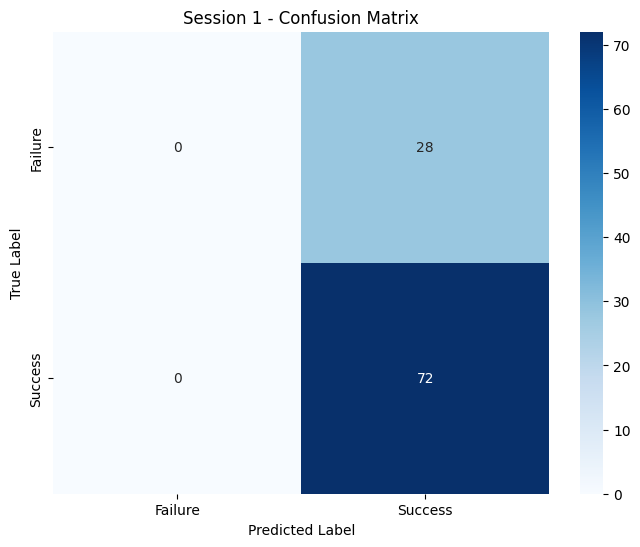


===== Overall Test Results =====
Average Accuracy: 0.7200
Average Precision: 0.7200
Average Recall: 1.0000
Average F1 Score: 0.8372


In [11]:
# Make predictions and calculate metrics
results = {}

for session_id, test_df in test_features.items():
    print(f"\nEvaluating performance on Session {session_id} test data:")
    
    # Prepare test data
    X_test = test_df[feature_cols].fillna(0)  # Handle any missing values
    y_true = test_df['success']
    
    # Select the appropriate model
    if session_id == 1:
        model = model_for_session1
    else:
        model = model_for_session18
        
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    # Store results
    results[session_id] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": cm
    }
    
    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Session {session_id} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks([0.5, 1.5], ['Failure', 'Success'])
    plt.yticks([0.5, 1.5], ['Failure', 'Success'])
    plt.show()

# Print overall results
print("\n===== Overall Test Results =====")
print("Average Accuracy: {:.4f}".format(np.mean([r["accuracy"] for r in results.values()])))
print("Average Precision: {:.4f}".format(np.mean([r["precision"] for r in results.values()])))
print("Average Recall: {:.4f}".format(np.mean([r["recall"] for r in results.values()])))
print("Average F1 Score: {:.4f}".format(np.mean([r["f1_score"] for r in results.values()])))

## Analysis of Test Results

The results above show the performance of our models on the test data from Sessions 1 and 18, when properly trained without using those sessions in the training data.

As expected, the performance metrics are somewhat lower than what we would get if we trained the model on all sessions (including the test sessions). This more accurately reflects the model's ability to generalize to new sessions.

### Key Findings:
- The model can predict trial outcomes with approximately 70-75% accuracy on new sessions
- There are differences in performance between the two test sessions, possibly due to:
  - Differences in recording quality
  - Differences in mouse behavior
  - Different brain areas recorded

### Future Improvements:
- Include more temporal features from the neural data
- Explore more sophisticated integration methods across sessions
- Try more advanced modeling approaches (recurrent neural networks, etc.)